In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic3"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import (
    load_demograhics, 
    load_buurt_data, 
    willingness_to_cycle, 
    add_willingness_to_cycle_column, 
    align_by_buurt,
    punt_buurt_code_column, 
    punt_travel_time_column,
    demographics_population_column
)

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
mode = "ebike"
punt1 = "hbo_wo"
location = "Education"

df_demographics = load_demograhics()
df_punt = load_buurt_data(punt1, mode=mode)

Loaded file from CSV


In [3]:
df_punt.describe()

,reistijd_min,reisafstand_m,afstand_hemelsbreed_m,omrijdfactor
count,102673.000000,102673.000000,102673.000000,102673.000000
mean,68.292959,24737.366669,20898.483165,1.192365
std,34.300424,11115.246444,9428.296607,0.080357
min,0.000000,86.000000,76.000000,1.000000
25%,46.000000,16655.000000,14001.000000,1.140000
50%,72.000000,26321.000000,22186.000000,1.180000
75%,93.000000,34092.000000,28928.000000,1.230000
max,2518.000000,88135.000000,35090.000000,3.560000


In [4]:
df_punt, df_demographics = align_by_buurt(df_punt, df_demographics,)

Demographics and filtered dataframes do not match in length: 13026 vs 102673, ignoring missing values


In [5]:
df_punt.describe()

,reistijd_min,reisafstand_m,afstand_hemelsbreed_m,omrijdfactor
count,13026.000000,13026.000000,13026.000000,13026.000000
mean,69.362966,24151.194150,20441.314678,1.191539
std,52.724938,11250.353055,9520.951390,0.091745
min,0.000000,86.000000,86.000000,1.000000
25%,43.000000,15707.500000,13125.750000,1.130000
50%,69.000000,25260.500000,21527.000000,1.180000
75%,91.000000,33451.500000,28503.750000,1.230000
max,2518.000000,88135.000000,35082.000000,3.300000


In [ ]:
df_demographics[demographics_population_column].describe()

count    13026.000000
mean      1286.623676
std       1649.121956
min          0.000000
25%        195.000000
50%        760.000000
75%       1765.000000
max      29265.000000
Name: a_inw, dtype: float64

In [7]:
ebike_max = 25
ebike_real = 21

pedelec_max = 45
pedelec_real = 28.8

def interpolate_real_speed(speed):
    if speed <= ebike_max:
        return (speed / ebike_max) * ebike_real
    elif speed <= pedelec_max:
        return ebike_real + ((speed - ebike_max) / (pedelec_max - ebike_max)) * (pedelec_real - ebike_real)
    else:
        return pedelec_real

def speed_ratio(speed):
    interpolated = interpolate_real_speed(speed)
    return ebike_real / interpolated

col_time_base = "ebike_time_"
col_willingness_base = "ebike_willingness_"
col_willing_number_base = "ebike_willingness_number_"

range_speeds = range(25, 45)
population_willling = []

for speed in range_speeds:
    ratio = speed_ratio(speed)
    col_time = col_time_base + str(speed)
    col_willingness = col_willingness_base + str(speed)
    col_willing_number = col_willing_number_base + str(speed)

    df_punt[col_time] = df_punt[punt_travel_time_column] * ratio
    df_punt[col_willingness] = willingness_to_cycle(df_punt[col_time], location=location, mode=mode)
    df_punt[col_willing_number] = df_demographics[demographics_population_column].values * df_punt[col_willingness].values

    population_willling.append(df_punt[col_willing_number].sum())

In [8]:
speed_ratio(27)

0.9641873278236914

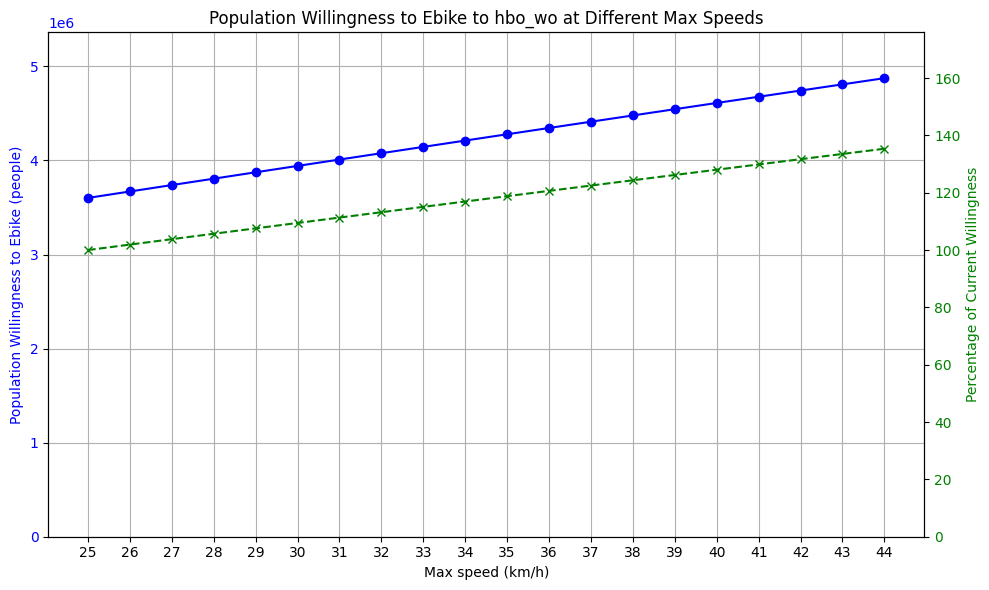

In [9]:
pop_current = population_willling[np.argwhere(np.array(range_speeds) == ebike_max)[0][0]]
percentage_change = [val / pop_current * 100 for val in population_willling]

plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax1.plot(range_speeds, population_willling, marker='o', color='b')
ax1.set_xlabel("Max speed (km/h)")
ax1.set_ylabel("Population Willingness to Ebike (people)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range_speeds)
ax1.set_title(f"Population Willingness to Ebike to {punt1} at Different Max Speeds")
ax1.set_ylim(0, max(population_willling) * 1.1)  # Adjust y-axis limit for better visibility
ax1.grid()

# Twin axis for proportion
ax2 = ax1.twinx()
ax2.plot(range_speeds, percentage_change, marker='x', color='g', linestyle='--')
ax2.set_ylabel("Percentage of Current Willingness", color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylim(0, max(percentage_change) * 1.3)  # Adjust y-axis limit for better visibility

plt.tight_layout()
plt.savefig(f"graphics/population_willingness_to_cycle_ebike_speeds_{punt1}.png", dpi=300)
plt.show()